# Synchrony Metric Comparison

This notebook is intended to compare the quality of spike synchrony metrics on simulated synchronized vs. desynchronized data.

In [1]:
PROJECT_PATH = 'G:/Shared drives/visual_encoding'

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# elephant
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient, covariance

# elephant reqs
import neo
import quantities as pq

# project-specific imports
import sys
sys.path.append('../..')
sys.path.append('../../sim_field')
from sim_field.funcs import sim_ou_process
from sim_field.timescale import comp_tau_fooof
from sim_field.utils import get_spike_times, convolve_psps
from allen_vc.analysis import compute_pyspike_metrics, compute_cv, compute_fano_factor

print("Imported!")

Imported!


In [60]:
# simulation settings
N_SECONDS = 10
FS = 1000 # sampling frequency
N_NEURONS = 100
MEAN_RATE = 10 # average rate of each neuron (Hz)

# random process params
ALPHA = 1.
TAU_C = 25 / 1000

# metric calculation settings
N_ITERS = 100

In [52]:
def sim_homogeneous_pool(rand_process=None, n_neurons=5, mu=20, variance=300, n_seconds=1, fs=1000,
                         tau_c=0.01):
    """
    *** modied to input white noise process or any random process ***
    
    simulate population spiking of N neurons firing at firing_rate each, return a
    spike trains roster of size (n_seconds*fs by n_neurons)

    Parameters
    ----------
    n_neurons : scalar, optional
        number of neurons in population. The default is 5.
    mu : scalar, optional
        mean of random walk. The default is 20.
    sigma : scalar, optional
        std of random walk. The default is 300.
    n_seconds : scalar, optional
        duration of signal (s). The default is 1.
    fs : scalar, optional
        sampling frequency (Hz). The default is 1000.
    tau : scalar, optional
        timescale (sec). The default is 0.01.

    Returns
    -------
    spikes : 2D array
        spike trains.
    rand_process : 1D array
        instantanious firing rate.

    """

    if rand_process is None:
        # simulate randon process (Ornstein-Uhlenbeck)
        rand_process, _ = sim_ou_process(n_seconds, fs, mu=mu, sigma=variance**0.5, tau=tau_c)
        # rand_process[rand_process < 0] = 0 # ensure all positive values

    # generate spikes from OU process
    spikes = np.zeros([n_neurons, len(rand_process)])

    # turn rates into spikes
    for j_bin in range(len(rand_process)):
        for i_neuron in range(n_neurons):
            if rand_process[j_bin] / fs > np.random.uniform():
                spikes[i_neuron, j_bin] = 1
    
    return spikes, rand_process

In [53]:
def run_homogeneouspool_sim(sync=True):
    # imports
    from scipy.signal import detrend

    # simulate spiking
    if sync:
        # simulate synchronized spiking
        spikes, rand_process = sim_homogeneous_pool(n_neurons=N_NEURONS, mu=MEAN_RATE, variance=MEAN_RATE**2, n_seconds=N_SECONDS, fs=FS, tau_c=TAU_C)
    
    else:
        # simulate desynchronized spiking
        rand_white = np.random.normal(loc=MEAN_RATE, scale=MEAN_RATE**0.5, size=N_SECONDS*FS)
        spikes, _ = sim_homogeneous_pool(rand_process=rand_white, n_neurons=N_NEURONS, n_seconds=N_SECONDS, fs=FS)

    # get spike times
    time = np.linspace(0,N_SECONDS,spikes.shape[1])
    spike_times = []
    for i_cell in range(len(spikes)):
        spike_times.append(get_spike_times(spikes[i_cell], time))

    # simulate LFP
    pop_spikes = np.sum(spikes, axis=0)
    lfp, freq = convolve_psps(pop_spikes, FS)
    lfp = detrend(lfp, type='constant')
    
    return spike_times, pop_spikes, lfp

In [54]:
# SPIKE-distance
# Coefficient of Variation
# Fano Factor
# Time-Scale

In [55]:
def comp_spike_stats(spikes):
    
    # create lists to store individual spiketrain values
    fano_factors = []
    coefficients_of_variation = []
    
    # concatenate all spiketrains at the end to calculate SPIKE-distance
    spike_trains = []
    
    for train in spikes:
        
        # convert to neo object and compute metrics
        neo_obj = neo.SpikeTrain(train, units=pq.s, t_start=0, t_stop=N_SECONDS)
        fano_factors.append(compute_fano_factor(neo_obj, 1*pq.s))
        coefficients_of_variation.append(compute_cv(neo_obj))
        spike_trains.append(neo_obj)
        
    spk_dist, _ = compute_pyspike_metrics(spike_trains)
    
    return spk_dist, np.mean(coefficients_of_variation), np.mean(fano_factors)
    

In [58]:
def calculate_sim_metrics(iters=1):
    
    metrics = []
    
    # calculate both sync and desync metrics for a number of iterations
    for i in tqdm(range(iters)):
        
        sync_spikes, _, sync_sig = run_homogeneouspool_sim(sync=True)
        desync_spikes, _, desync_sig = run_homogeneouspool_sim(sync=False)
        
        # compute tau based on lfp signal
        sync_tau = comp_tau_fooof(sync_sig, FS)
        desync_tau = comp_tau_fooof(desync_sig, FS)
        
        # append all metrics
        metrics.append([True, sync_tau] + list(comp_spike_stats(sync_spikes)))
        metrics.append([False, desync_tau] + list(comp_spike_stats(desync_spikes)))
        
    # create and return DataFrame
    df = pd.DataFrame(metrics, columns=['synchronized', 'tau', 'spike_distance', 'mean_coefficient_of_variation',
                                       'mean_fano_factor'])
    
    return df

In [61]:
df = calculate_sim_metrics(iters=N_ITERS)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
  1%|▊                                                                                 | 1/100 [00:08<14:23,  8.73s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s)

 17%|█████████████▊                                                                   | 17/100 [01:56<08:44,  6.31s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 18%|██████████████▌                                                                  | 18/100 [02:03<08:49,  6.46s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 19%|███████████████▍                                                                 | 19/100 [02:08<08:26,  6.25s/it]C:\User

 33%|██████████████████████████▋                                                      | 33/100 [03:42<07:01,  6.30s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 34%|███████████████████████████▌

 50%|████████████████████████████████████████▌                                        | 50/100 [05:40<05:36,  6.74s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 51%|█████████████████████████████████████████▎                                       | 51/100 [05:50<06:16,  7.68s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 52%|██████████████████████████████████████████                                       | 52/100 [05:57<06:10,  7.73s/it]C:\User

 65%|████████████████████████████████████████████████████▋                            | 65/100 [07:30<03:57,  6.78s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 66%|█████████████████████████████████████████████████████▍                           | 66/100 [07:37<03:49,  6.76s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 68%|███████████████████████████████████████████████████████                          | 68/100 [07:53<04:01,  7.55s/it]C:\User

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [08:52<02:38,  6.90s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [08:58<02:27,  6.71s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s)

C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [10:03<01:16,  6.34s/it]C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
C:\Users\User\.conda\envs\neomne\

In [62]:
df

,synchronized,tau,spike_distance,mean_coefficient_of_variation,mean_fano_factor
0,True,0.039355,0.257931,1.121260,1.238301
1,False,0.012412,0.294198,0.975071,0.873619
2,True,0.025089,0.266505,1.085563,1.147272
3,False,0.007822,0.295592,0.989362,0.962873
4,True,0.027160,0.267381,1.065737,1.013456
...,...,...,...,...,...
195,False,0.010503,0.296115,0.994313,0.966651
196,True,0.030830,0.265020,1.102663,1.215178
197,False,0.011502,0.295568,0.985800,0.867815
198,True,0.035484,0.259235,1.124091,1.158162


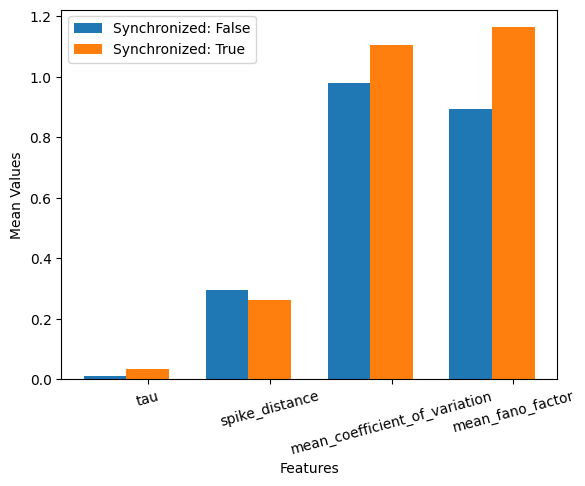

In [101]:
# Group the data by the "synchronized" column and calculate mean values
grouped = df.groupby("synchronized").mean()

# Define the columns to plot
columns_to_plot = ["tau", "spike_distance", "mean_coefficient_of_variation", "mean_fano_factor"]

# Create the grouped barplot
fig, ax = plt.subplots()
width = 0.35
x = range(len(columns_to_plot))

for i, (label, group) in enumerate(grouped.iterrows()):
    ax.bar(
        [pos + width * i for pos in x],
        group[columns_to_plot],
        width,
        label=f"Synchronized: {label}"
    )

ax.set_xlabel("Features")
ax.set_ylabel("Mean Values")
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(columns_to_plot, rotation=15)
ax.legend()

plt.show()


### PCA

In [89]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df.iloc[:, 1:])

PCA()

In [94]:
pd.DataFrame(pca.components_)

,0,1,2,3
0,0.054525,-0.075440,0.323397,0.941674
1,-0.185491,0.234699,-0.893007,0.336226
2,0.771338,-0.560002,-0.302049,0.014206
3,0.606348,0.790963,0.081973,0.000106


In [91]:
pca.explained_variance_ratio_

array([9.62359262e-01, 3.62066271e-02, 9.73645722e-04, 4.60464932e-04])